# Text Classification Using Naive Bayes: New Headline Categorization

In this notebook, I take in a [large dataset of labeled news headlines](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv) and use natural langauge processing methods to create a classification algorithm. I explore some of the common methods for text processing from natural language processing (NLP) provided by the python library Natural Language Toolkit (NLTK).

## Required Modules

- `numpy`: for linear algebra operations
- `pandas`: to read and transform the dataset
- `matplotlib` helps with the creation of graphs and charts
- `re`: provides regular expression interpreting, which I use for some basic text-processing including removing non-alphanumeric characters
- `nltk`: NLTK provides pre-made text processing functions including tokenization, part-of-speech tagging (POS tagging), lemmatization, and stemming. Additionally, I use the list of English stop-words provided by NLTK.
- `sklearn`: Sci-kit learn contains many machine learning utilities including a function split datasets into training and test sets, objects to help with hyperparamter tuning, text feature extraction utilities, and machine learning models

In [31]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

The following cell downloads packages that support nltk's functions including tokenization, lemmatization, etc. (Only needs to be done once per machine, hence why it is commented out)

In [16]:
# import nltk
# nltk.download()

## Reading and exploring the data

This dataset stores news headlines, descriptions, and classifications in a comma-separated values (.csv) file. The author provided a training and test split already, but I chose to merge these back together so I can choose the size of the test set later on. Also, merging these datasets now means I can preprocess them together prior to splitting into training and test splits. This could also be done through using a pipeline, but I elected for the combined approach for this project.

In [17]:
# https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv
train = pd.read_csv("train.csv", names=['class', 'title', 'description'])
test = pd.read_csv("test.csv", names=['class', 'title', 'description'])

df = train.append(test)

/tmp/ipykernel_13021/4201545040.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train.append(test)


Viewing the first few entries of this dataset shows the general form. In this notebook, I explore how well a model performs using the title column alone, ignoring the description variable. In the future, I may revisit this to see if the model performs better when using the description as well.

In [18]:
df.head()

,class,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Next, I create a new column with the label of each classification for ease of understanding when looking at a given record.

Text(0, 0.5, 'Count')

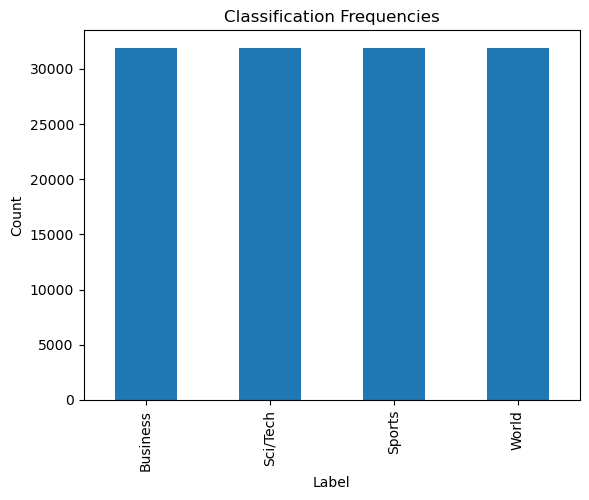

In [19]:
labels = ['World', 'Sports', 'Business', 'Sci/Tech']
df['label'] = df['class'].apply(lambda x : labels[x - 1])

fig, ax = plt.subplots()
df['label'].value_counts().plot(kind='bar')
ax.set_title('Classification Frequencies')
ax.set_xlabel('Label')
ax.set_ylabel('Count')

Evidently, the data source created an idealized situation where the records are uniformly distributed across classifications. Accordingly, I later use accuracy as a metric for evaluating my model, which may not be appropriate if the distribution skewed strongly towards a particular classification. At an extreme, if 90% of records were classified as "business," the model could achieve 90% accuracy simply by labeling everything as "business."

## Text Preprocessing

Evidently, computers cannot process natural language with the ease that a human might, so the end goal of this section is to map each article title to a vector that can be passed to any variety of machine learning models.

### Basic Preprocssing with Regular Expressions

Regular expressions (RegEx) can solve many basic natural langauge processing tasks such as extracting or substituting text matching a given form/pattern. Here, I use it, combined with Pandas' built-in string methods, to remove special characters that don't contribute much (or any, in some cases) meaning to these headlines. I treat hyphens as a special case, choosing to split hyphenated words into their base words by replacing hyphens with spaces. I make every headline lowercase so later on during the tokenization process words words with different capitlizations are treated the same ("Commerical" need not be treated differently than "commercial" in this use case).

In [20]:
#unidecode?

df['title'] = df['title'].str.lower().apply(lambda x : re.sub('[.(),:#;&]', '', x))
df['title'] = df['title'].apply(lambda x : x.replace('-', ' '))

### Tokenization, Lemmatization, Stemming, and Stop Words with NLTK

Now that I have "normalized" headlines (all lowercased, without special characters), I use nltk functions to further process these headlines. First, I tokenize each headline. Tokenization breaks a string of words (a sentence, or in this case a headline) and breaks it into distinct words and punctuation. Breaking the headlines into tokens allows other nltk functions to operate word-by-word.

Next, I trim down the tokens, eliminating stop words. There is no single definition of what defines a proper set of stop words, but in general, stop words are words that do not contribute meaning to the sentence. For example, in the sentence "An orange is a tasty fruit," almost all of the meaning is preserved by removing the articles "an" and "a," leaving "orange is tasty fruit." I use NLTK's provided set of English stop words.

With the set of tokens that have some degree of importance to the meaning of the headline, I next use `pos_tag` to identify the part of speech of each token. NLTK's lemmatizer performs better when provided with the part of speech, so I store these for use in the next step. However, the lemmatizer doesn't use the same part of speech encodings that the POS tagger outputs. I create the `tag_map()` function to map the POS-tagger-tags to the smaller set of POS tags that the lemmatizer accepts.

To further consolidate the "vocabulary" that my model with work with later, I use lemmatization and stemming to map words to their "base form."

After these processing steps, I rejoin the tokens to create a string I pass to the next stage in the process: TF-IDF vectorizing.

In [21]:
lemmatizer = WordNetLemmatizer()
stemmer = EnglishStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(string: str):
	tokens = word_tokenize(string)

	tokens = [token for token in tokens if token not in stop_words]

	tagged = pos_tag(tokens)

	def tag_map(pos: str):
		if pos[0] == 'N':
			return 'n'
		if pos[0] == 'V':
			return 'v'
		if pos[0] == 'J':
			return 'a'
		if pos[0] == 'R':
			return 'r'
		return 'n'

	final = []	

	for word, tag in tagged:
		lemmatized = lemmatizer.lemmatize(word, tag_map(tag))
		final.append(stemmer.stem(lemmatized))
	
	return ''.join([f"{word} " for word in final])

In [22]:
df['title'] = df['title'].apply(preprocess)

### The Train-Test Split

While more data in general can help create better models in most cases, using all available data precludes any way of determining how well the model will perform. For example, a model may perform well on data it has already seen in training, or may overfit if the training set doesn't represent the greater population. In this case, a model may achieve very high accuracy on the training data, but perform very poorly when predicting out of sample examples.

As such, I split my data into a training and test sets, in hopes that using the test set to gauge model performance will help to identify overfitting. I also choose to stratify by the classification variable, making sure that the training and test splits have equal numbers of each of the classes.

In [23]:
X = df['title']
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

### From Words to Numbers: TF-IDF

Now I have a more consolidated set of words that hopefully convey the same or similar meaning, but this data is still not suitable to pass to a machine learning model. For this reason, I use a common method of mapping sentences/documents to vectors called Term Frequency-Inverse Document Frequency (TF-IDF). The first part, term frequency measure the frequency of words across the whole vocabulary. Using term frequency alone may lead to problems when documents differ in length, as a term may appear more often in a longer document, even if this term occurs relatively infrequently in the document consider the document's length. For this reason, term frequencies are scaled by their frequencies across the whole vocabulary so as not to misrepresent documents solely based on their length.

In [25]:
tfvect = TfidfVectorizer()

X_train_tfidf = tfvect.fit_transform(X_train)
X_test_tfidf = tfvect.transform(X_test)

## Modeling: Naive Bayes

Now that I have represented the words as vectors, I can train a machine learning model to predict classes based on headlines. I choose to use a multinomial naive bayes model for its simplicity and partly out of convention, as this type of model is commonly used for tasks like this.

In [37]:
mnb = MultinomialNB()

mnb.fit(X_train_tfidf, y_train)

test_preds = mnb.predict(X_test_tfidf)

accuracy_score(test_preds, y_test)

0.8587679300845446

Before any tuning, this model already performs well, correctly classifying 85.9% of headlines in the test set. To see if hyperparameter tuning might yield any better results, I use `GridSearchCV` to automatically find the best parameter set by performing multiple runs with different crossvalidation sets for each set of parameters. Here, `MultinomialNB` only takes one parameter alpha, so it is less of a "grid" search and more of a "line" search.

In [38]:
params = {'alpha': np.logspace(0,-9, num=100)}
gridsearch = GridSearchCV(estimator=mnb, param_grid=params, verbose=1, scoring='accuracy')
gridsearch.fit(X_train_tfidf, y_train)
print(gridsearch.best_params_)

test_preds = gridsearch.predict(X_test_tfidf)
accuracy_score(test_preds, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'alpha': 0.1873817422860384}


0.8612140210886292

### Error Analysis with a Confusion Matrix

Tuning the alpha value results in a modest increase in model accuracy. Now, with my tuned model, I use another method of model evaluation for classification models: a confusion matrix. A confusion matrix visualizes the frequency of correct and incorrect classifications.

In [33]:
cm = confusion_matrix(test_preds, y_test)

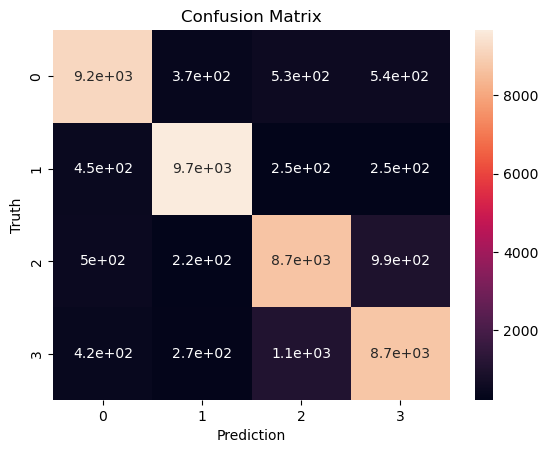

In [40]:
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
plt.show()

As shown by the lightly colored main diagonal, this model correctly predicts in the vast majority of cases. However, this visualization gives insight into areas to explore in the future. Namely, the most common misclassifications are category 2 being categorized as category 3 and vice versa. This suggests that more feature engineering might be in order to determine ways to make sure the model might better distinguish these two classifications. This misclassification makes some sense as there likely is significant crossover between science/technology news and business news, but more analysis could lead to other features to include.

## Next Steps

- Carry out the error analysis mentioned in the last paragraph and conduct further feature engineering, especially to better distinguish category 2 from category 3. 
- Use other modeling techniques: SVM, KNN, Tree ensembles, Neural networks
- Try out using SpaCY instead of NLTK

I started experienting using SVM and achieved slightly better performance prior to hyperparameter tuning. However, this model takes much longer to train, so I have not gone through a complete hyperparameter tuning process.

In [ ]:
# svm = SVC()
# svm.fit(X_train_tfidf, y_train)

# test_preds_svm = svm.predict(X_test_tfidf)

# np.sum(test_preds_svm == y_test) / len(y_test)

0.8762121212121212

In [ ]:
# params_svm = {'kernel': ['poly', 'rbf', 'sigmoid']}

# gridsearch_svm = GridSearchCV(estimator=SVC(), param_grid=params_svm, verbose=2, scoring='accuracy')


# gridsearch_svm.fit(X_train_tfidf, y_train)

# print(gridsearch.best_params_)
# print(gridsearch.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ........................................kernel=poly; total time=19.6min
[CV] END ........................................kernel=poly; total time=19.5min
[CV] END ........................................kernel=poly; total time=19.7min
